在流程之间共享一个大型矩阵有几个好处：
- 只有一个拷贝意味着没有浪费内存。
- 复制大块RAM不会浪费时间。
- 您可以在进程之间共享部分结果。

回想一下“usingnumpy”中使用numpy的pi估计演示，我们发现随机数生成是一个串行过程。在这里，我们可以想象共享一个大数组的分叉进程，每个进程使用一个不同种子的随机数生成器用随机数填充数组的一部分，因此完成一个大随机块的生成要比单个进程更快。

为了验证这一点，我们修改了即将发布的演示，创建了一个大的随机矩阵（10000）× 320000个元素），并将矩阵拆分为四个段，其中并行调用random（两种情况下，一次一行）。串行处理耗时53秒，并行处理耗时29秒。请参阅“并行系统中的随机数”，了解并行随机数生成的一些危险。

在本节的其余部分，我们将使用一个简化的演示来说明这一点，同时保持易于验证。

在图中 9-18，你可以在伊恩的笔记本电脑上看到htop的输出。它显示父进程的四个子进程（PID为27628），其中所有五个进程共享一个10000×320000个元素的双倍数组。这个阵列的一个拷贝成本为25.6gb，而笔记本电脑只有32gb，你可以从htop的进程表中看到，Mem读数显示最大内存为31.1gb。

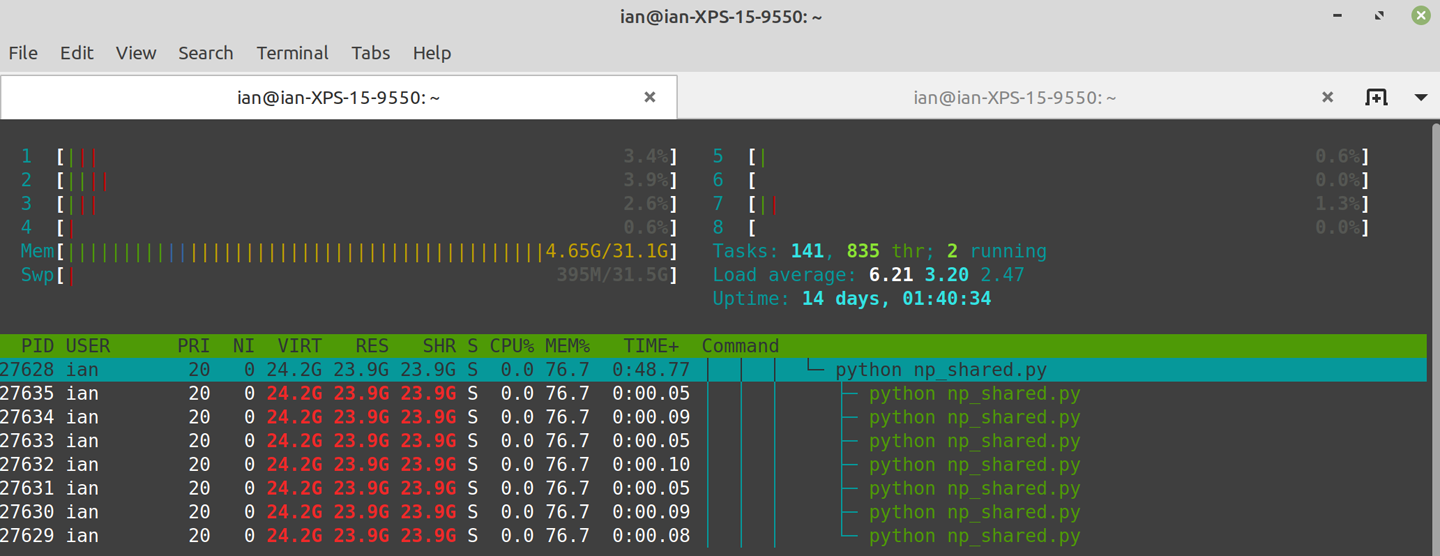

在示例中 9-28，我们已经在这个共享阵列上启动了四个进程。没有复制阵列；每个进程都在查看相同的大内存块，每个进程都有一组不同的索引。每隔几千行，worker输出当前索引及其PID，这样我们就可以观察它的行为。worker的作业很琐碎，它将检查当前元素是否仍设置为默认值（因此我们知道没有其他进程已经修改了它），然后它将用当前PID覆盖该值。一旦worker完成，我们将返回父进程并再次打印数组。这一次，我们看到它充满了PIDs而不是42。

例9-28。在共享阵列上运worker_fn

完成后，程序现在退出，数组被删除。

通过使用ps和pmap，我们可以了解Linux下的每个进程。例子 9-30显示调用ps的结果。分解此命令行：

- ps告诉我们这个过程。
- -A列出所有进程。
- -o pid，size，vsize，cmd输出pid，size信息和命令名。
- grep用于过滤所有其他结果，只为我们的演示留下行。

输出中显示了父进程（PID 27628）及其四个分叉子进程。结果与我们在htop中看到的相似。我们可以使用pmap查看每个进程的内存映射，用-x请求扩展输出。我们使用模式s来列出被标记为共享的内存块。在父进程和子进程中，我们看到它们之间共享一个25000000 KB（25.6 GB）的块。

例9-30。使用pmap和ps来研究操作系统的进程视图

我们将使用multprocessing.Array将一个共享内存块分配为1D数组，然后从这个对象实例化一个numpy数组并将其重塑为2D数组。现在我们有了一个numpy包装的内存块，它可以在进程之间共享并寻址，就好像它是一个普通的numpy数组一样。numpy没有管理RAM；多重处理。数组正在管理它。

在示例中 9-31，您可以看到每个分叉进程都可以访问全局主数组。当forked进程拥有numpy对象的副本时，对象访问的底层字节被存储为共享内存。我们的worker_fn将用当前进程标识符覆盖所选行（通过idx）。

例9-31。使用多处理共享numpy数组的worker_fn

在我们的例子中 9-32，我们将经历三个主要阶段：
1. 构建一个共享的multiprocessing.Array并将其转换为numpy数组。
2. 在数组中设置一个默认值，并派生四个进程来并行处理数组。
3. 在进程返回后验证数组的内容。

通常，您会设置一个numpy数组并在单个进程中处理它，可能会执行类似于 arr = np.array((100, 5), dtype=np.float_) 的操作。这在单个进程中很好，但不能在读写两个进程之间共享这些数据。

诀窍是生成一个共享的字节块。一种方法是创建multiprocessing.Array。默认情况下，数组被包装在锁中以防止并发编辑，但是我们不需要这个锁，因为我们会小心访问模式。为了向其他团队成员清楚地传达这一点，有必要明确并设置lock=False。

如果不设置lock=False，则将有一个对象而不是对字节的引用，并且需要调用 .get_obj() 来获取字节。通过调用 .get_obj() ，您绕过了锁，因此首先不明确说明这一点没有任何价值。

接下来，我们获取这个可共享字节块，并使用frombuffer在其周围包装一个numpy数组。dtype是可选的，但是由于我们在传递字节，所以显式是明智的。我们重新调整字节的形状，这样就可以将字节作为一个二维数组来处理。默认情况下，数组值设置为0。例子 9-32显示了我们的__main__。

设置numpy数组以共享：

In [ ]:
if __name__ == '__main__':
    DEFAULT_VALUE = 42
    NBR_OF_PROCESSES = 4

    # create a block of bytes, reshape into a local numpy array
    NBR_ITEMS_IN_ARRAY = SIZE_A * SIZE_B
    shared_array_base = multiprocessing.Array(ctypes.c_double,
                                              NBR_ITEMS_IN_ARRAY, lock=False)
    main_nparray = np.frombuffer(shared_array_base, dtype=ctypes.c_double)
    main_nparray = main_nparray.reshape(SIZE_A, SIZE_B)
    # assert no copy was made
    assert main_nparray.base.base is shared_array_base
    print("Created shared array with {:,} nbytes".format(main_nparray.nbytes))
    print("Shared array id is {} in PID {}".format(id(main_nparray), os.getpid()))
    print("Starting with an array of 0 values:")
    print(main_nparray)
    print()

为了确认我们的进程是在我们开始使用的相同数据块上运行的，我们将每个项设置为一个DEFAULT_VALUE（我们再次使用，生命、宇宙和一切的答案）-您将在示例顶部看到这一点. 接下来，我们构建一个进程池（本例中为四个），然后通过调用map发送成批的行索引。

_main__ 用于使用多处理共享numpy数组

In [ ]:
# Modify the data via our local numpy array
    main_nparray.fill(DEFAULT_VALUE)
    print("Original array filled with value {}:".format(DEFAULT_VALUE))
    print(main_nparray)

    input("Press a key to start workers using multiprocessing...")
    print()

    # create a pool of processes that will share the memory block
    # of the global numpy array, share the reference to the underlying
    # block of data so we can build a numpy array wrapper in the new processes
    pool = multiprocessing.Pool(processes=NBR_OF_PROCESSES)
    # perform a map where each row index is passed as a parameter to the
    # worker_fn
    pool.map(worker_fn, range(SIZE_A))

In [ ]:
print("Verification - extracting unique values from {:,} items\n in the numpy \
           array (this might be slow)...".format(NBR_ITEMS_IN_ARRAY))
    # main_nparray.flat iterates over the contents of the array, it doesn't
    # make a copy
    counter = Counter(main_nparray.flat)
    print("Unique values in main_nparray:")
    tbl = PrettyTable(["PID", "Count"])
    for pid, count in list(counter.items()):
        tbl.add_row([pid, count])
    print(tbl)

    total_items_set_in_array = sum(counter.values())

    # check that we have set every item in the array away from DEFAULT_VALUE
    assert DEFAULT_VALUE not in list(counter.keys())
    # check that we have accounted for every item in the array
    assert total_items_set_in_array == NBR_ITEMS_IN_ARRAY
    # check that we have NBR_OF_PROCESSES of unique keys to confirm that every
    # process did some of the work
    assert len(counter) == NBR_OF_PROCESSES

    input("Press a key to exit...")

我们刚刚创建了一个一维字节数组，将其转换为二维数组，在四个进程之间共享该数组，并允许它们在同一内存块上并发处理。这个方法可以帮助你并行处理多个内核。要小心对相同数据点的并发访问，但是如果要避免同步问题，就必须在多处理中使用锁，这会降低代码的速度。

并行地共享numpy矩阵而不进行复制只对一小部分问题很重要，但是当它起作用时，它就真的起作用了。它需要额外的几行代码，并且需要一些健全性检查，以确保您确实没有在进程之间复制数据。